Zadanie kwalifikacyjne:
W oparciu o dane dotyczące kursów walut wyciągane za pomocą API NBP (http://api.nbp.pl/)
prosimy o przygotowanie programu automatyzującego analizę inwestycji w 3 wybrane waluty.
Inwestowaną kwotą jest 1000 zł, które ma być w całości przeznaczone na zakup 3 walut
przechowywanych przez okres 30 dni.

• Data rozpoczęcia może być parametrem wejściowym ew. procedury.

• Procentowy podział 3 walut może być również określony losowo lub jako parametr
(np. 30% USD, 40% EUR, 30%HUF).
Celem zadania jest automatyzacja tej analizy i prezentacja wniosków ( max. 1 strona / 1 slajd )
omawiająca historię tej inwestycji:
    
A. Prezentacja może być oparta na wykresach powstających automatycznie w Twoim
programie

B. Prezentacja (slajd lub dashboard) powinna odpowiadać na przykładowe pytania:
- jak procentowo rozłożona była inwestowana kwota ?

- jak zmieniała się wartość Twojego portfela ?

- jak wyglądał procentowy udział walut na końcu okresu inwestycji ?


Ważne!

2. Inwestycja nie musi być dochodowa
– poszukiwanie najbardziej dochodowej inwestycji nie jest celem tego zadania
3. Dla uproszczenia analizy można posłużyć się średnim kursem i nie musisz uwzględniać
różnych cen zakupu i sprzedaży
4. Waluty są kupowane we wskazanej dacie i po 30 dniach jest oceniana wartość portfela
– w tym okresie nie są dokonywane żadne dodatkowe transakcje kupna/sprzedaży.

In [1]:
import datetime
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import clear_output
import requests
import random
import time

TabelaA = requests.get("http://api.nbp.pl/api/exchangerates/tables/A/")
TabelaA = TabelaA.json()

currency_list = []
for i in range(0, len(TabelaA[0]["rates"])):
    currency_list.append(TabelaA[0]["rates"][i]["code"]) 
    
#widgets 1-3, currency list
w1=widgets.Dropdown(
    options=currency_list,
    value='THB',
    description='currency:',
    disabled=False)           
w2=widgets.Dropdown(
    options=currency_list,
    value='USD',
    description='currency:',
    disabled=False)  
w3=widgets.Dropdown(
    options=currency_list,
    value='AUD',
    description='currency:',
    disabled=False)  

#widgets 4, stock
w4=widgets.IntText(
    value=1000,
    description='Stock [PLN]:',
    disabled=False
)

#widgets 1a-3a, currency percentage
w1a=widgets.FloatSlider(
    value=0.333,
    min=0,
    max=1,
    step=0.001,
    description='Percentage:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)
w2a=widgets.FloatSlider(
    value=0.333,
    min=0,
    max=1,
    step=0.001,
    description='Percentage:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)
w3a=widgets.FloatSlider(
    value=0.334,
    min=0,
    max=1,
    step=0.001,
    description='Percentage:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)
#widgets 1a-3a, currency percentage, sum to 100%, slider changes.
def handle_slider_change1(change):
    w2a.value = w2a.value-(change.new-change.old)
    if w1a.value + w2a.value + w3a.value != 1:
        w3a.value=1-w2a.value-w1a.value
    
w1a.observe(handle_slider_change1, names='value')

def handle_slider_change2(change):
    w3a.value = w3a.value-(change.new-change.old)
    if w1a.value + w2a.value + w3a.value != 1:
        w2a.value=1-w3a.value-w1a.value

w2a.observe(handle_slider_change2, names='value')

def handle_slider_change3(change):
    #w1a.value = w1a.value-(change.new-change.old)
    if w1a.value + w2a.value + w3a.value != 1:
        w3a.value=1-w2a.value-w1a.value

w3a.observe(handle_slider_change3, names='value')

button2 = widgets.Button(description="Random currency!",disabled=False)

#generate random percentage stock for sliders
def on_button_clicked2(b):
    button2.disabled=True
    x = []
    for i in range(3):
        x.append(random.random())
    y=[]
    for i in x:
        y.append(i/sum(x))
    for i in range(0,3):
        widget_nr = random.randint(0,1)#widget number 3 it only computate by sum
        if widget_nr==0:
            w1a.value=y[0]
        if widget_nr==1:
            w2a.value=y[1]
    time.sleep(1)
    button2.disabled=False

#widgets 4, stock = 1000
def handle_stock_change(change):
    w4.value = 1000
    
w4.observe(handle_stock_change, names='value')

#date from 01.02.2002 to last date - 30
date=widgets.DatePicker(description='Pick a Date',value=datetime.datetime(2023, 2, 1))
mindate=datetime.date(2002, 2, 1)
maxdate=datetime.datetime.strptime(TabelaA[0]["effectiveDate"], "%Y-%m-%d").date() - datetime.timedelta(days=30)

def date_change(change):
    if date.value < mindate:
        date.value = mindate
        print("Min date: ")
        print(mindate)
    if date.value >  maxdate:
        date.value = maxdate
        print("Max date (the last published exchange rate date-30): ")
        print(maxdate)
        
date.observe(date_change, names='value')

try:
  date.value=date.value.date()
except:
  print("warning, date transformed before")

        
def calculate_changes(currency=w1.value, date=date.value):
    stringBuilder = "http://api.nbp.pl/api/exchangerates/rates/A/" + currency + "/" +str(date) +"/" +str(date + datetime.timedelta(days=30)) +"/?format=json"
    Currency1 = requests.get(stringBuilder)
    Currency1  = Currency1.json()
    Currency1list = []
    for x in Currency1["rates"]:
      wartosc=float(x.get("mid"))
      Currency1list.append(wartosc)
    Changes = []
    for i in range(0, len(Currency1list)-1):
        Changes.append(Currency1list[i]/Currency1list[i+1])
    return Changes

def calculate_portfolio(currency1=w1.value, pct1=w1a.value,
                        currency2=w2.value, pct2=w2a.value,
                        currency3=w3.value, pct3=w3a.value,
                        stock=w4.value, date=date.value):
    Changes1=calculate_changes(currency=currency1, date=date)
    Changes2=calculate_changes(currency=currency2, date=date)
    Changes3=calculate_changes(currency=currency2, date=date)
    pct1=pct1*stock
    pct2=pct2*stock
    pct3=pct3*stock
    Portfolio_value=[]
    Portfolio_value.append(pct1+pct2+pct3)
    for i in range(0, len(Changes1)):
        pct1=pct1*Changes1[i]
        pct2=pct2*Changes2[i]
        pct3=pct3*Changes3[i]
        Portfolio_value.append(pct1+pct2+pct3)
    print(str(currency1) + " in stock: " + str(pct1)+". pct: "+str(pct1/(pct1+pct2+pct3)))
    print(str(currency2) + " in stock: " + str(pct2)+". pct: "+str(pct2/(pct1+pct2+pct3)))
    print(str(currency3) + " in stock: " + str(pct3)+". pct: "+str(pct3/(pct1+pct2+pct3)))
    print("Stock value: " +str((pct1+pct2+pct3)))
    return Portfolio_value

button = widgets.Button(description="Check investiotion!")

output = widgets.Output()

IntText(value=1000, description='Stock [PLN]:')

Dropdown(description='currency:', options=('THB', 'USD', 'AUD', 'HKD', 'CAD', 'NZD', 'SGD', 'EUR', 'HUF', 'CHF…

FloatSlider(value=0.333, continuous_update=False, description='Percentage:', max=1.0, readout_format='.3f', st…

Dropdown(description='currency:', index=1, options=('THB', 'USD', 'AUD', 'HKD', 'CAD', 'NZD', 'SGD', 'EUR', 'H…

FloatSlider(value=0.333, continuous_update=False, description='Percentage:', max=1.0, readout_format='.3f', st…

Dropdown(description='currency:', index=2, options=('THB', 'USD', 'AUD', 'HKD', 'CAD', 'NZD', 'SGD', 'EUR', 'H…

FloatSlider(value=0.334, continuous_update=False, description='Percentage:', max=1.0, readout_format='.3f', st…

Button(description='Random currency!', style=ButtonStyle())

DatePicker(value=datetime.date(2023, 2, 1), description='Pick a Date')

Button(description='Check investiotion!', style=ButtonStyle())

Output()

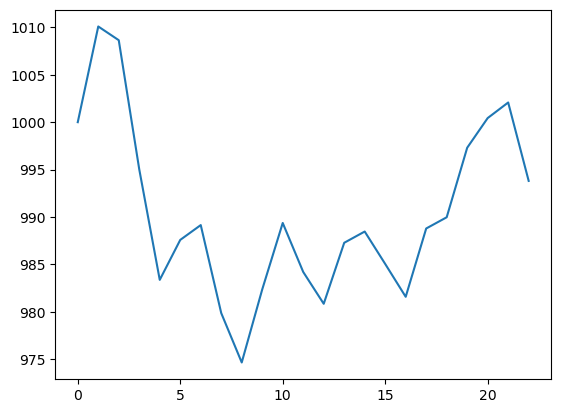

In [2]:
clear_output(wait=False)
output.value=""
def on_button_clicked(b):
    with output:
        output.value=""
        clear_output(wait=False)
        print("Output generated!")
        print("Investition report start date:")
        print(date.value)
        print("Investition report end date:")
        print(str(date.value + datetime.timedelta(days=30)))
        print("Investition input data:")
        print(w1.value)
        print(w1a.value)
        print(w2.value)
        print(w2a.value)
        print(w3.value)
        print(w3a.value)
        print("Investition output data:")
        portfolio_value = calculate_portfolio(currency1=w1.value, pct1=w1a.value,
                        currency2=w2.value, pct2=w2a.value,
                        currency3=w3.value, pct3=w3a.value,
                        stock=w4.value, date=date.value)
        plt.cla()
        plt.plot(portfolio_value)

button.on_click(on_button_clicked)
button2.on_click(on_button_clicked2)

display(w4,w1,w1a,w2,w2a,w3,w3a,button2, date,button, output)